# Title : Long Short Term Memory Recurrent         Neural Network Regression Tutorial By Daniel

## Content:  I will create one Sine curve(blue line) which predict (Learn)another Cos  curve(red line)

> Are you exciting now?  Follow me, step by step  !!! Just training with CPU. Don't worry about the dame high price of GPU !!!

## 1. Import Package

In [1]:
%matplotlib notebook
import tensorflow as tf # Google Deep Learning Framework
import numpy as np
import matplotlib.pyplot as plt

## 2. Setting Hyperparameter 

In [2]:
BATCH_START = 0         # Create Batch Data Index
TIME_STEPS = 20         # backpropagation through time 
BATCH_SIZE = 50         
INPUT_SIZE = 1          # input size of sin
OUTPUT_SIZE = 1         # cos size of 
CELL_SIZE = 10          # the hidden unit size of RNN
LEARNING_RATE = 0.01    # learning rate

# 3. LSTM RNN Model

In [3]:
def weight_variable(shape, name='weights'):
    """
    Weight
    """
    initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
    return tf.get_variable(shape=shape, initializer=initializer, 
                           name=name)

In [4]:
def bias_variable(shape, name='biases'):
    """
    Biases
    """
    initializer = tf.constant_initializer(0.1)
    return tf.get_variable(name=name, shape=shape, initializer=initializer)

In [5]:
def ms_error(y_target, y_pre):
    """
    Mean Square Error
    https://stackoverflow.com/questions/41338509/tensorflow-mean-squared-error-loss-function
    """
    return tf.reduce_mean(tf.squared_difference(y_target, y_pre))

### 3.1 Add Input Layer

In [6]:
def add_input_layer(x_placeholder, input_size, cell_size, n_steps):
    
    # Due to x_placeholder is 3 Dimension, we should convert it into 2 Demension
    l_in_x = tf.reshape(x_placeholder,[-1, input_size], name='3D_To_2D') #(batch*n_step, in_size)
    
    # Ws (in_size, cell_size)
    Ws_in = weight_variable([input_size, cell_size])
    
    # bs (cell_size,)
    bs_in = bias_variable([cell_size,])
    # l_in_y = (batch*n_steps, cell_size)
    with tf.name_scope('Wx_plus_b'):
        l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
    # reshape l_in_y ==> (batch, n_steps, cell_size)
    l_in_y = tf.reshape(l_in_y, [-1, n_steps,cell_size], name='2D_To_3D')
    return l_in_y

## 3.2 Add LSTM Cell

In [7]:
def add_cell(cell_size, batch_size, l_in_y):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(cell_size, forget_bias=1.9,
                                            state_is_tuple=True)
    with tf.name_scope('initial_state'):
        cell_init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    
    cell_outputs, cell_final_state = tf.nn.dynamic_rnn(lstm_cell,
                                                       l_in_y,
                                                       initial_state= cell_init_state, 
                                                       time_major=False)
    
    return cell_outputs, cell_init_state, cell_final_state

## 3.3 Add Output Layer

In [8]:
def add_output_layer(cell_outputs, cell_size, output_size):
    # shape = (batch * steps, cell_size)
    l_out_x = tf.reshape(cell_outputs, [-1, cell_size], name='3D_To_2D')
    Ws_out = weight_variable([cell_size, output_size])
    bs_out = bias_variable([output_size,])
    # shape = (batch * steps, output_size)
    with tf.name_scope('Wx_plus_b'):
        pred = tf.matmul(l_out_x, Ws_out) + bs_out
        return pred

## 3.4 Compute Cost

In [9]:
def compute_cost(pred, y_placeholder, batch_size, n_steps):
    losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    [tf.reshape(pred,[-1], name='reshape_pred')],
    [tf.reshape(y_placeholder,[-1],name='reshape_target')],
    [tf.ones([batch_size * n_steps], dtype=tf.float32)],
    average_across_timesteps=True,
    softmax_loss_function = ms_error,
    name='losses'
    )
    with tf.name_scope('average_cost'):
        cost = tf.div(tf.reduce_sum(losses, name='losses_sum'),
                      batch_size,
                      name="average_cost")
        tf.summary.scalar('cost', cost)
        
        return cost

## 3.4 Create LSTM RNN Model

In [10]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
    
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size

        """
        LSTM RNN Model Architecture
        """ 
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size],
                                name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size],
                                name='ys')
        with tf.variable_scope('in_hidden'):
            self.l_in_y = add_input_layer(self.xs, input_size, cell_size, n_steps)
        with tf.variable_scope('LSTM_cell'):
            self.cell_outputs, self.cell_init_state, self.cell_final_state = add_cell(cell_size, batch_size, 
                                                                                      self.l_in_y)
        with tf.variable_scope('out_hidden'):
            self.pred = add_output_layer(self.cell_outputs, cell_size, output_size)
       
        with tf.name_scope('cost'):
            self.cost = compute_cost(self.pred, self.ys, batch_size, n_steps)
        
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.cost)
      
   

## 4.Initial Model & Generate TensorFlow Event Files

In [ ]:
# Initial Long Short Term Memory Recurrent Neural Network
model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE,CELL_SIZE, BATCH_SIZE)

# Combine all 
merged = tf.summary.merge_all()


## 4.Train LSTM RNN Model

<IPython.core.display.Javascript object>


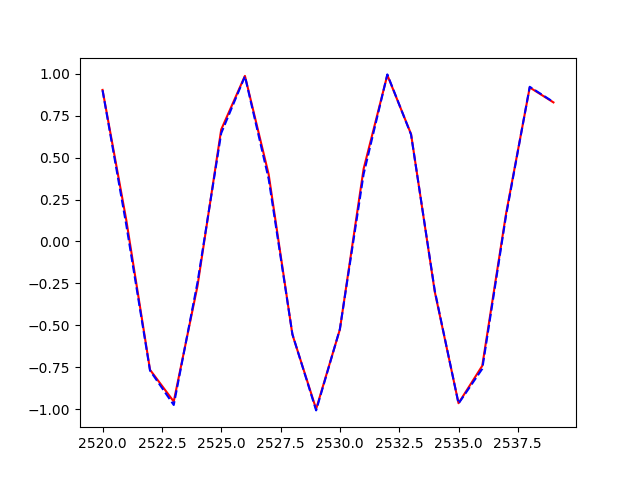

cost:  18.5806
cost:  1.0719
cost:  0.2705
cost:  0.0233
cost:  0.0223
cost:  0.0101
cost:  0.0052


In [ ]:
with tf.Session() as sess:
    
    writer = tf.summary.FileWriter("logs", sess.graph)  
    sess.run(tf.global_variables_initializer())
    
    #initialise the graph and settings
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()


   
    
    for i in range(200): 
        
     
        # Generate xs shape (50 batch, 20 steps)
        x_data = np.arange(BATCH_START, 
                           BATCH_START+TIME_STEPS*BATCH_SIZE).reshape(
                          (BATCH_SIZE,TIME_STEPS))

        # Sine Curve
        seq = np.sin(x_data)[:,:,np.newaxis]
        
        # Cos Curve
        res = np.cos(x_data)[:,:,np.newaxis]

        BATCH_START += TIME_STEPS

        if i == 0:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
            }
        else: 
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state
            }

        # Trainning 
        _, cost, state, pred = sess.run([model.train_op, model.cost, model.cell_final_state, model.pred],feed_dict = feed_dict)

        # plotting
        ax.clear() # - Clear
        ax.plot(x_data[0, :], res[0].flatten(), 'r', x_data[0, :], pred.flatten()[:TIME_STEPS], 'b--') # fit the line
        fig.canvas.draw()   # draw
        #time.sleep(0.5)    #sleep


        # Obeser the cost value in every 20 steps
        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result,i)

